# Import Required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #(Augmented Dickey-Fuller test)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Load & Inspect the Dataset

In [ ]:
tesla_df = pd.read_csv('/content/Tesla Stock Dataset.csv')
tesla_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [ ]:
print(tesla_df.describe())
print(tesla_df.info())

         Adj Close        Close         High          Low         Open  \
count  3654.000000  3654.000000  3654.000000  3654.000000  3654.000000   
mean     81.695980    81.695980    83.507689    79.793275    81.707033   
std     107.839958   107.839958   110.325408   105.251783   107.891905   
min       1.053333     1.053333     1.108667     0.998667     1.076000   
25%      12.098500    12.098500    12.371166    11.821833    12.164833   
50%      17.936666    17.936666    18.221666    17.679000    17.964667   
75%     177.992496   177.992496   182.605000   174.707504   178.017502   
max     479.859985   479.859985   488.540009   457.510010   475.899994   

             Volume  
count  3.654000e+03  
mean   9.667827e+07  
std    7.770996e+07  
min    1.777500e+06  
25%    4.899450e+07  
50%    8.203705e+07  
75%    1.223769e+08  
max    9.140820e+08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 7 columns):
 #   Column     Non-Null Coun

In [ ]:
# Convert the Date column to a datetime format and set it as the index.
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
tesla_df.set_index('Date', inplace=True)

In [ ]:
#Select the close column for analysis
close_data = tesla_df['Close']
close_data.dropna()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-12-27,431.660004
2024-12-30,417.410004
2024-12-31,403.839996


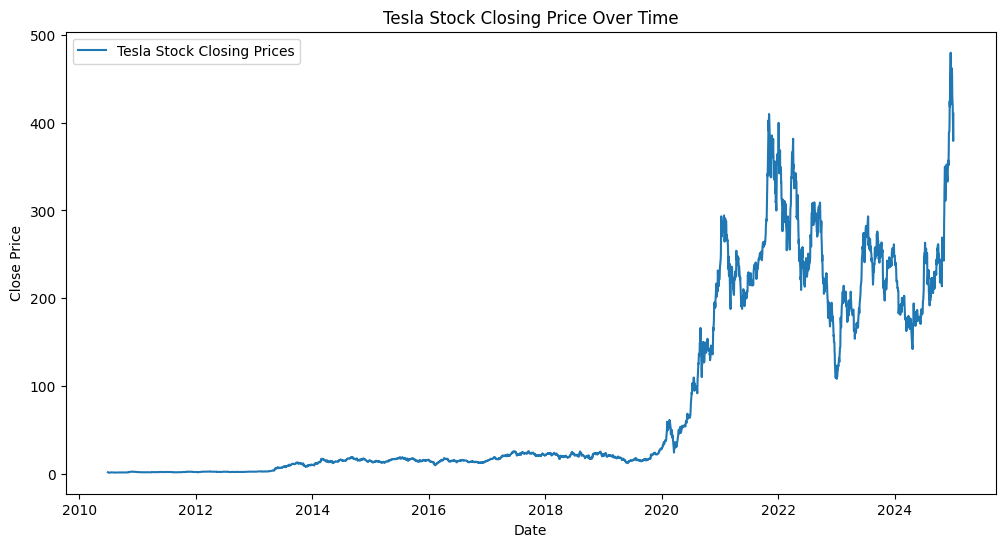

In [ ]:
#Plot the time series
plt.figure(figsize=(12,6))
plt.plot(close_data, label='Tesla Stock Closing Prices')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Decompose The Time Series

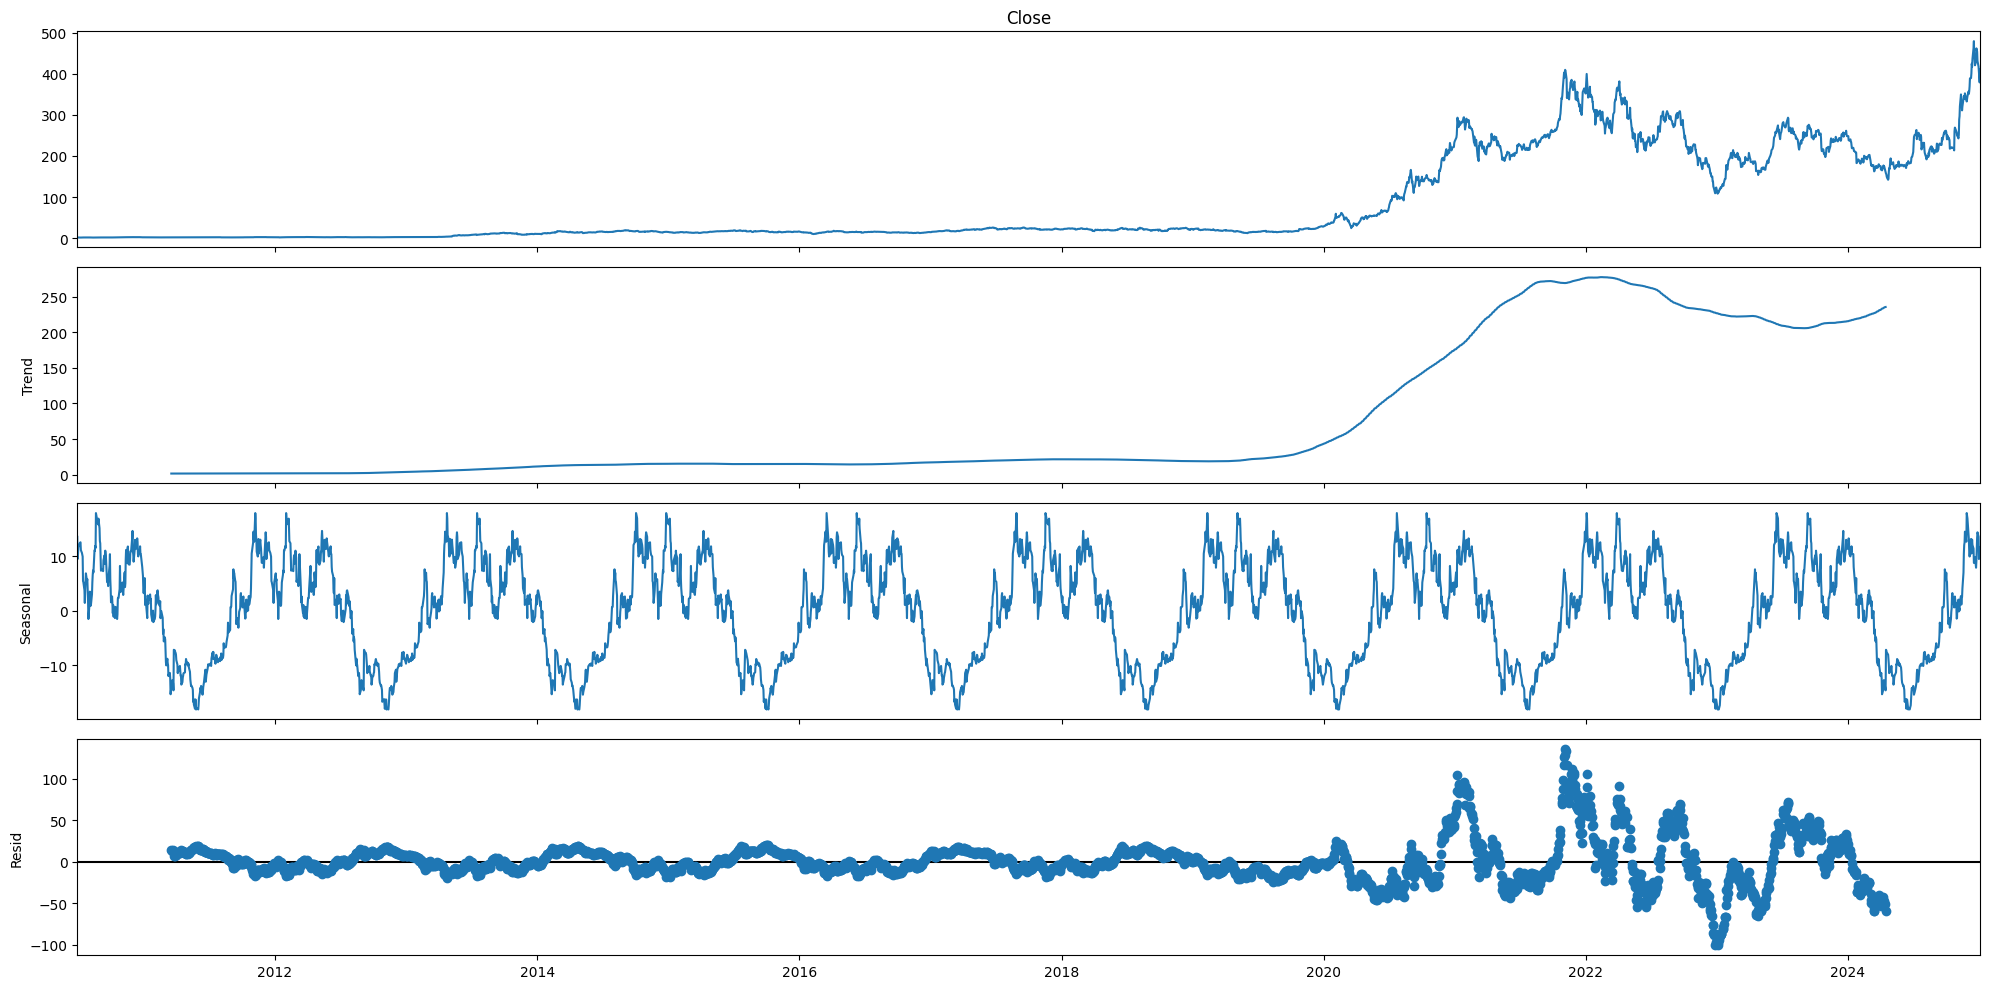

In [ ]:
#decompose the time series to observe the trends, seasonality and residuals
decomposition = seasonal_decompose(close_data, model='additive', period=365)
#plot the decomposition
plt.rcParams['figure.figsize'] = (20, 10)  # Adjust width and height as desired
decomposition.plot()
plt.show()

1. The `additive model` assumes that the time series is a sum of its components (trend + seasonality + residual). This is suitable when the seasonal fluctuations are relatively constant over time. Alternatively, a `multiplicative model` can be used if the seasonal variations change proportionally with the level of the time series.
2. `period=365` This crucial parameter defines the length of the seasonal cycle. In this case, it's set to 365, implying that the code is looking for patterns that repeat every 365 periods (likely representing a 365-day cycle, which could roughly correspond to Yearly seasonality in daily data).

1. **Trend**: The seasonal_decompose function isolates the long-term progression of the data, which is referred to as the trend. It essentially smooths out short-term fluctuations to reveal the underlying direction of the series.
2. **Seasonality**: The function identifies patterns that repeat at regular intervals (defined by the period parameter), which is the seasonality. This could be daily, weekly, monthly, or any other recurring pattern in the data.
3. **Residual**: After extracting the trend and seasonality, whatever variation remains is categorized as the residual. These are the unpredictable fluctuations or noise in the time series.

# Test For Stationarity

In [ ]:
#perform Augmented Dicky Fuller Test
result = adfuller(close_data)
print("ADF Statistic", result[0])
print("Print P value", result[1])
print("Critical Values", result[4])

#interpret the results
if result[1] <= 0.05:
  print("Time Series Data is Stationary")
else:
  print("Time Series Data is Non-Stationary, Differencing is required")

ADF Statistic -0.05011578267235439
Print P value 0.9541860444166193
Critical Values {'1%': -3.4321552239077326, '5%': -2.8623376471853903, '10%': -2.5671945999714625}
Time Series Data is Non-Stationary, Differencing is required


1. **Low p-value** (≤ 0.05) and a significantly negative ADF Statistic: The time series is likely stationary.
2. **High p-value** (> 0.05) and an ADF Statistic not much lower than Critical Values: The time series is likely non-stationary. You might need to apply differencing to make it stationary before using certain time series models.

## Differencing The Data

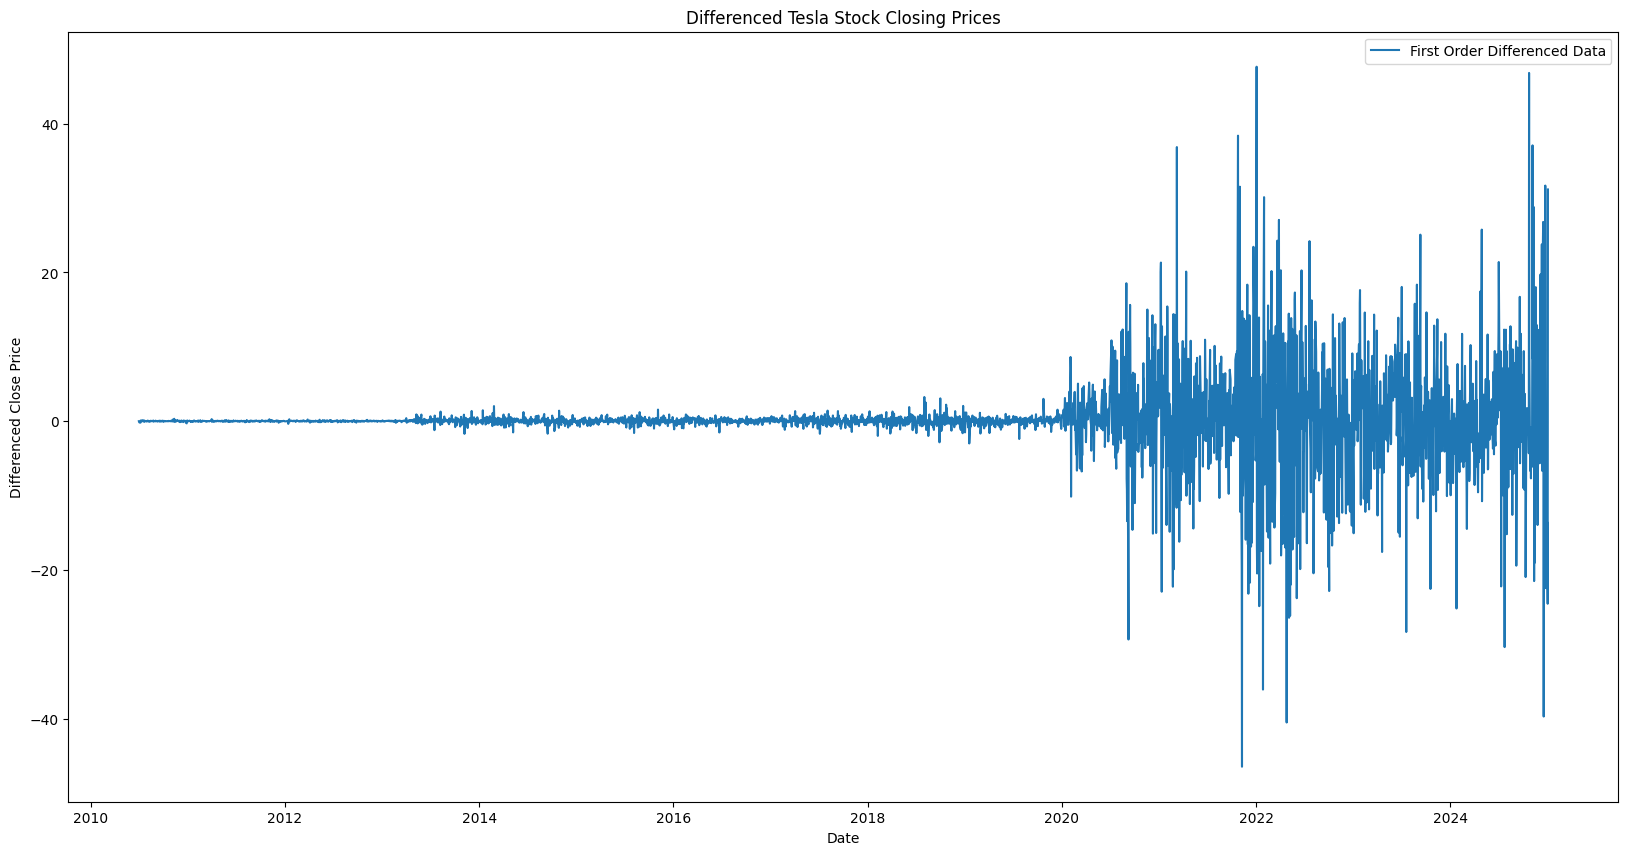

In [ ]:
#Apply first-order differencing
data_diff = close_data.diff()

#plot the differenced data
plt.plot(data_diff, label='First Order Differenced Data')
plt.title('Differenced Tesla Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

**Differencing** is a time series preprocessing technique used to make a time series stationary.

- How Much Differencing is Enough?

Start with **first-order differencing** (subtracting
𝑦
𝑡
−
𝑦
𝑡
−
1
y
t
​
 −y
t−1
​
 ).
If the series is still non-stationary, apply **second-order differencing** (difference the differenced series:
𝑦
𝑡
′
−
𝑦
𝑡
−
1
′
y
t
′
​
 −y
t−1
′
​
 ).

Avoid over-differencing, as it can lead to loss of information and increased noise.

In [ ]:
#apply adfuller test to check the stationary of differenced data
diff = adfuller(data_diff.dropna())
print("ADF Statistic", diff[0])
print("Print P value", diff[1])
print("Critical Values", diff[4])

#interpret the results
if diff[1] <= 0.05:
  print("Data is Stationary.")
else:
  print("Data is Non-Stationary, Differencing is required")

ADF Statistic -10.295479323156824
Print P value 3.4803426213445735e-18
Critical Values {'1%': -3.4321567201852456, '5%': -2.862338308122449, '10%': -2.5671949518327932}
Data is Stationary.


Finally, We have Stationary dataset. Now we can move on to next step, which is
`ACf` and `PACF` plots.



# ACF and PACF Plots

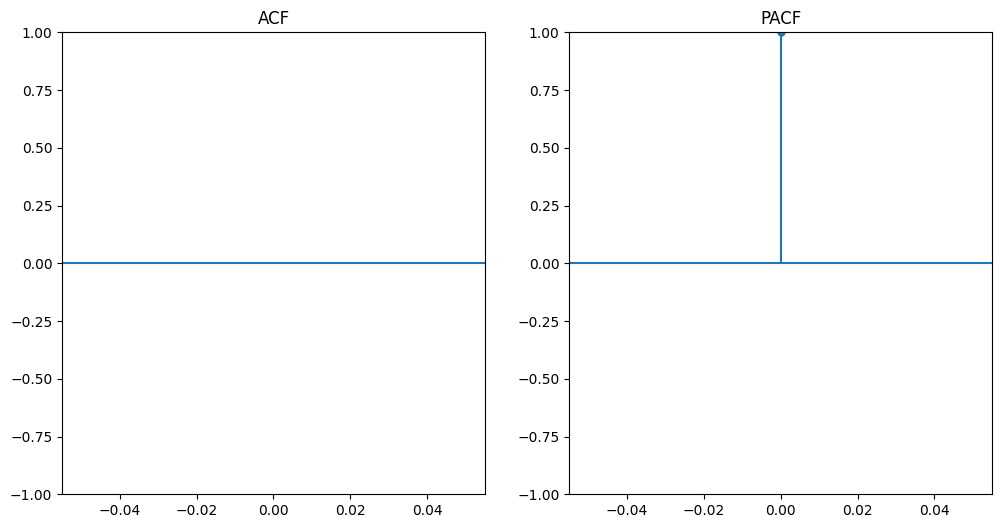

In [ ]:
#plot ACF and PACF on differenced data
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(data_diff, ax=ax[0], lags=30, title='ACF')
plot_pacf(data_diff, ax=ax[1], lags=30, title='PACF')
plt.show()

- **Data is already stationary**: If your time series is already stationary (as indicated by our ADF test), there might not be any significant autocorrelations left to detect. In such cases, ACF and PACF plots could be flat.

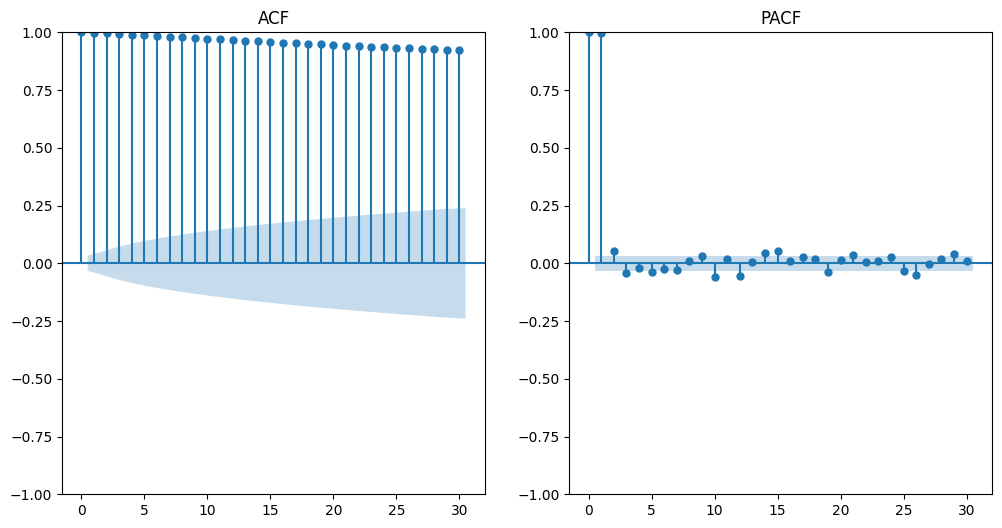

In [ ]:
#plot ACF and PACF on original data
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(close_data, ax=ax[0], lags=30, title='ACF')
plot_pacf(close_data, ax=ax[1], lags=30, title='PACF')
plt.show()

- It suggests your original data had autocorrelations, but they were removed by differencing.
- **Model diagnostics**: Even if no clear spikes are present, you can try fitting an ARIMA model with small values of p and q (e.g., ARIMA(1, d, 1)) and then check the model diagnostics. If the residuals are white noise, it suggests the model adequately captures the time series dynamics.

# Build The ARIMA Model

**Understanding ARIMA Parameters**

1. **p (AR order)**: Represents the number of autoregressive terms in the model. It indicates how many past values of the time series are used to predict the current value.
2. **d (Differencing order)**: Represents the number of times the time series needs to be differenced to make it stationary. It addresses trends and seasonality.
3. **q (MA order)**: Represents the number of moving average terms in the model. It indicates how many past forecast errors are used to predict the current value.

In [ ]:
# define parameters
p, d, q = 1, 1, 1
#define the model
arima_model = ARIMA(close_data, order=(p, d, q))
arima_result = arima_model.fit()

#print the summary of the ARIMA Model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3654
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11233.868
Date:                Fri, 24 Jan 2025   AIC                          22473.735
Time:                        05:27:39   BIC                          22492.345
Sample:                             0   HQIC                         22480.362
                               - 3654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9426      0.067    -14.149      0.000      -1.073      -0.812
ma.L1          0.9475      0.064     14.753      0.000       0.822       1.073
sigma2        27.4573      0.212    129.226      0.0

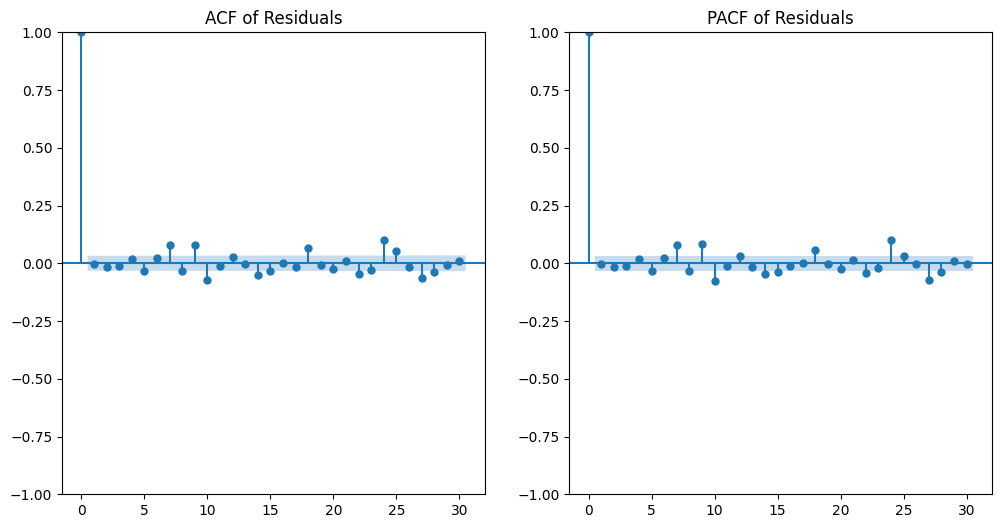

In [ ]:
residuals = arima_result.resid

fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(residuals, ax=ax[0], lags=30, title='ACF of Residuals')
plot_pacf(residuals, ax=ax[1], lags=30, title='PACF of Residuals')
plt.show()

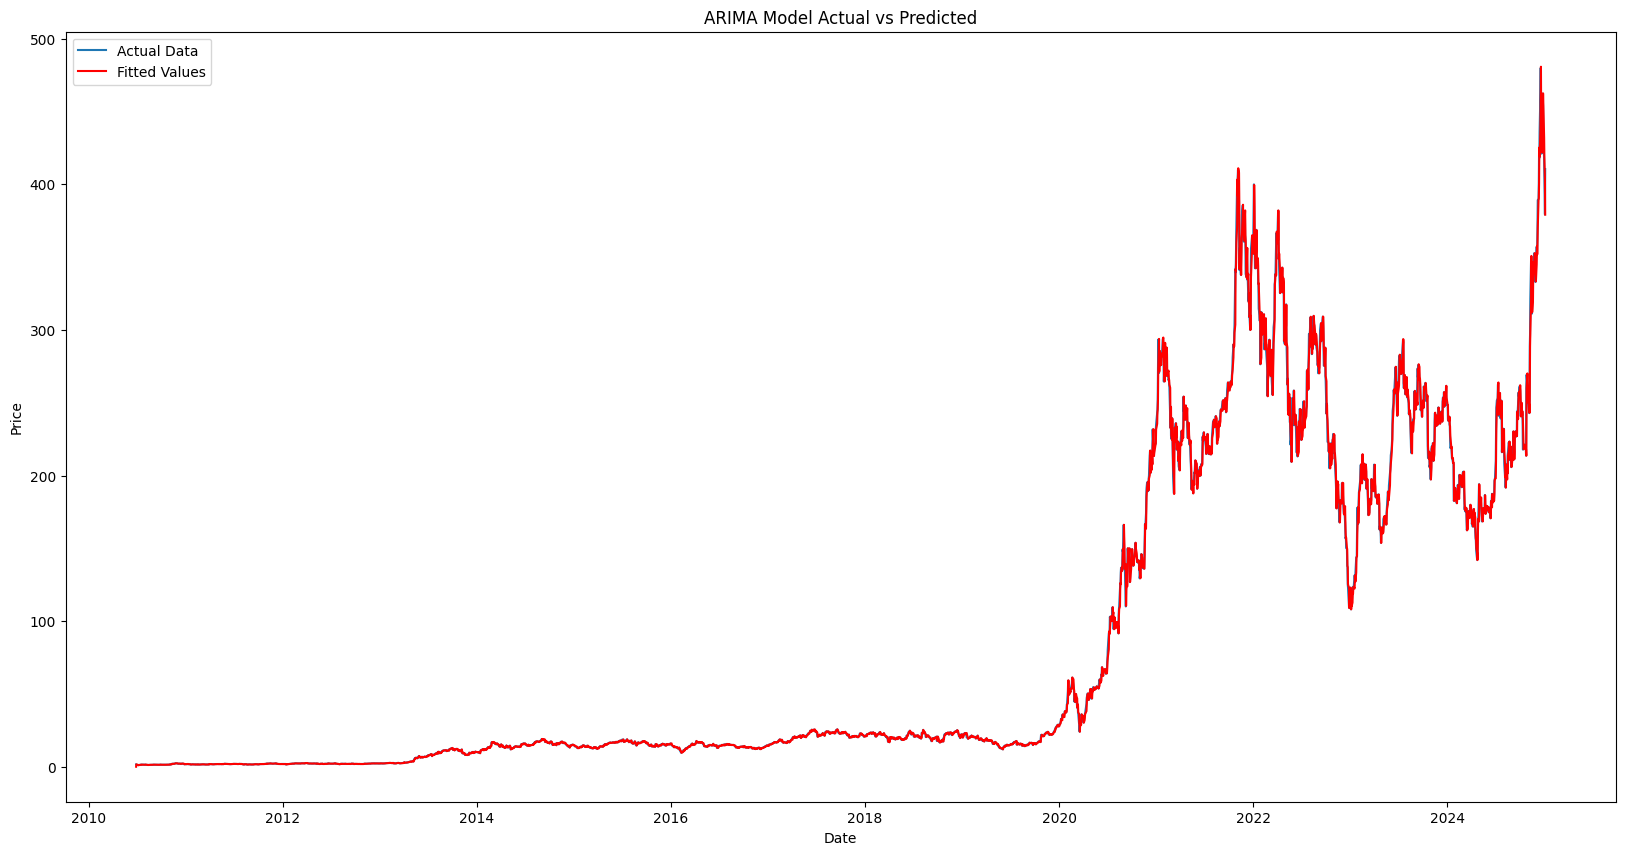

In [ ]:
#plot the fitted values against the actual data
plt.plot(close_data, label='Actual Data')
plt.plot(arima_result.fittedvalues, color='red', label='Fitted Values')
plt.title('ARIMA Model Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Build The Sarima Model

In [ ]:
#Define the model
p, d, q = 2, 1, 2
P, D, Q, seasonal_period =1, 1, 1, 12
sarima_model = SARIMAX(close_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
sarima_result = sarima_model.fit()

#summary of the model
print(sarima_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 3654
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood              -11224.112
Date:                              Fri, 24 Jan 2025   AIC                          22462.224
Time:                                      05:27:20   BIC                          22505.624
Sample:                                           0   HQIC                         22477.682
                                             - 3654                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1169      0.119     -0.981      0.326      -0.350       0.117
ar.L2          0.86

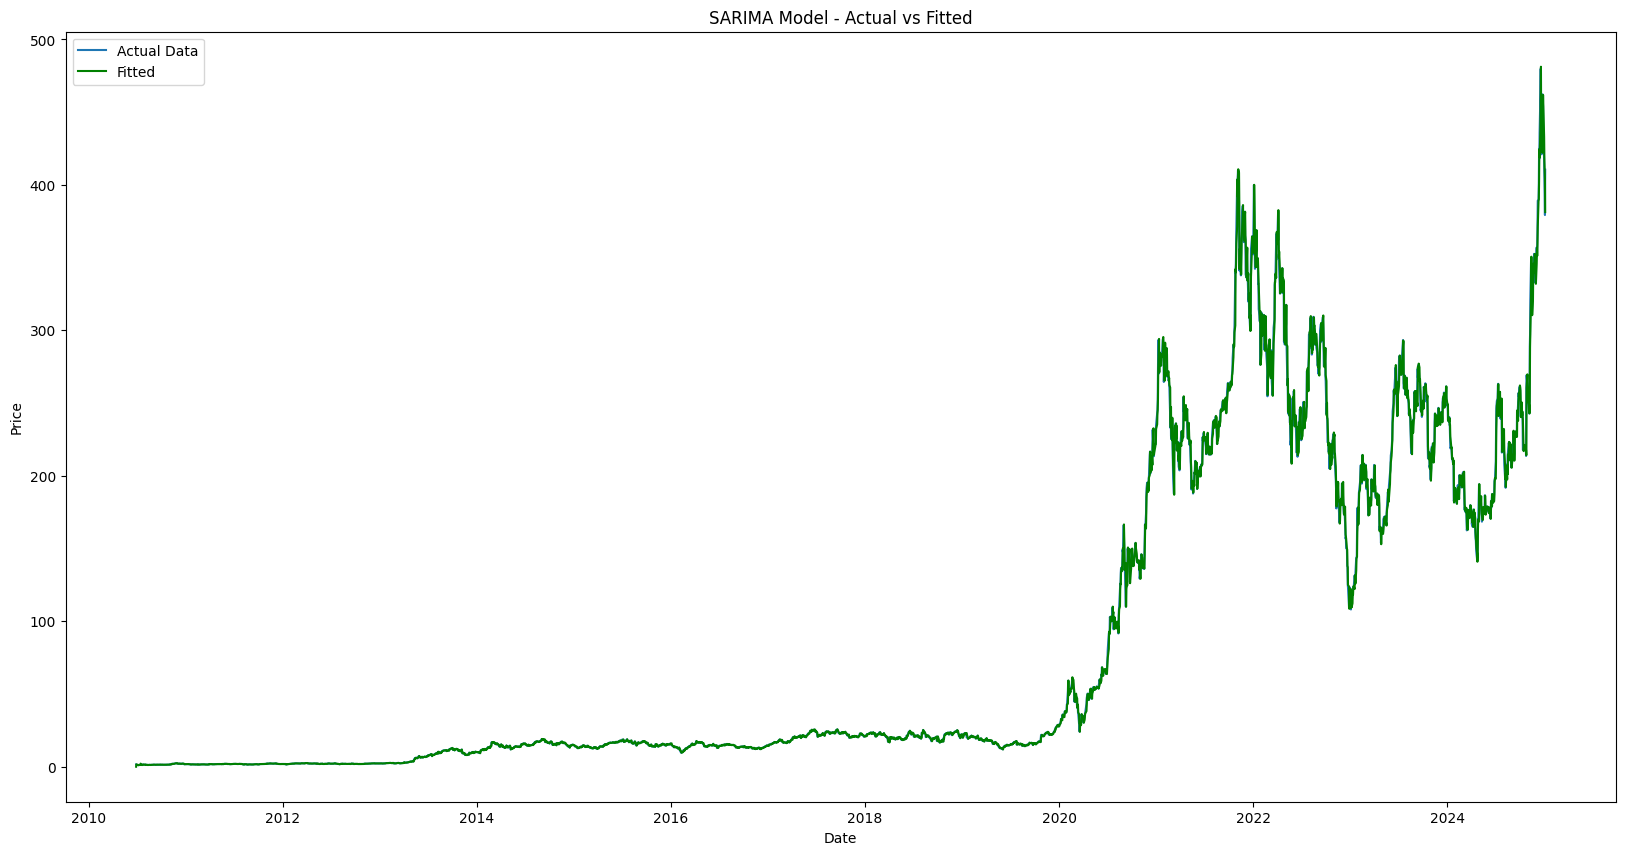

In [ ]:
#plot the fitted values against the actual values
plt.plot(close_data, label='Actual Data')
plt.plot(sarima_result.fittedvalues, color='green', label='Fitted')
plt.title('SARIMA Model - Actual vs Fitted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Forecast Future Prices


In [ ]:
#forecast the next 30 days
forecast_steps = 30
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(close_data.index[-1], periods=forecast_steps + 1, freq='B')[1:]
forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Bound': forecast.conf_int()['lower Close'],
    'Upper Bound': forecast.conf_int()['upper Close']
})

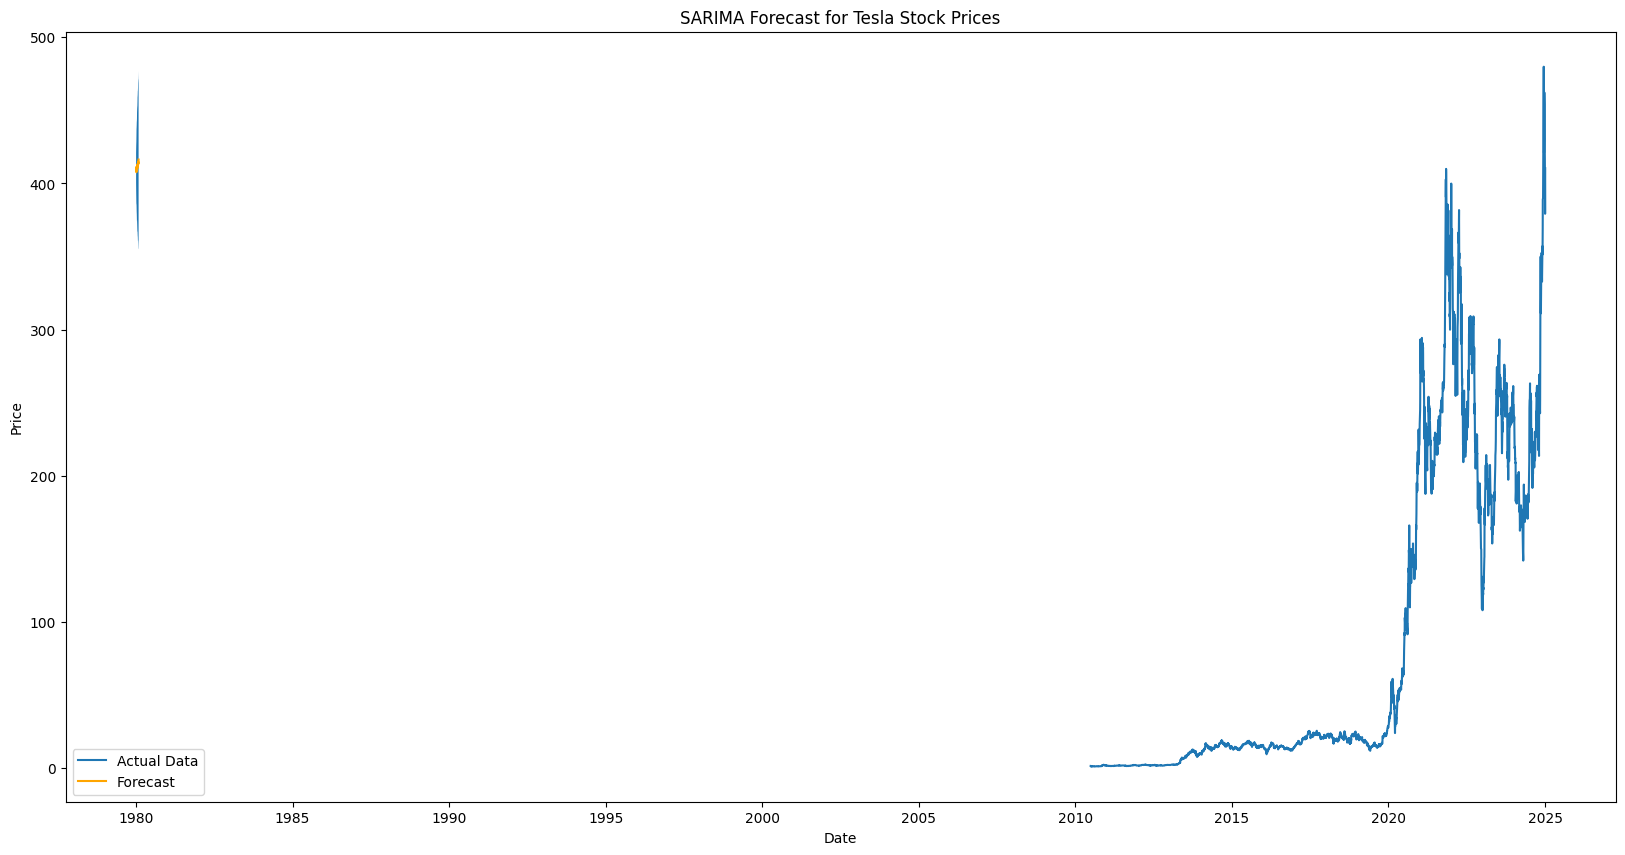

In [ ]:
#plot the forecast
plt.plot(close_data, label='Actual Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='orange')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'])
plt.title('SARIMA Forecast for Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
forecast_df.head()

,Forecast,Lower Bound,Upper Bound
3654,410.669669,400.384513,420.954826
3655,409.601143,394.966782,424.235504
3656,408.769279,390.794461,426.744096
3657,407.703065,386.865051,428.541078
3658,408.967569,385.610098,432.325041


#Evaluate The Model Performance

In [ ]:
# Calculate RMSE for ARIMA and SARIMA
arima_predictions = arima_result.predict(start=close_data.index[0], end=close_data.index[-1])
sarima_predictions = sarima_result.fittedvalues

arima_rmse = sqrt(mean_squared_error(close_data, arima_predictions))
sarima_rmse = sqrt(mean_squared_error(close_data, sarima_predictions))

print(f"ARIMA RMSE: {arima_rmse}")
print(f"SARIMA RMSE: {sarima_rmse}")


ARIMA RMSE: 5.239265493244145
SARIMA RMSE: 5.238676049084982
